100%|██████████| 26.4M/26.4M [03:24<00:00, 129kB/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 157kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.05MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Epoch 1: Train Loss = 0.4695, Val Loss = 0.3520
Epoch 2: Train Loss = 0.2992, Val Loss = 0.2803
Epoch 3: Train Loss = 0.2490, Val Loss = 0.2657
Epoch 4: Train Loss = 0.2159, Val Loss = 0.2470
Epoch 5: Train Loss = 0.1895, Val Loss = 0.2412
Epoch 6: Train Loss = 0.1672, Val Loss = 0.2295
Epoch 7: Train Loss = 0.1454, Val Loss = 0.2446
Epoch 8: Train Loss = 0.1279, Val Loss = 0.2378
Epoch 9: Train Loss = 0.1092, Val Loss = 0.2390
Early stopping triggered


C:\Users\Asrith S\AppData\Local\Temp\ipykernel_20340\1499770363.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


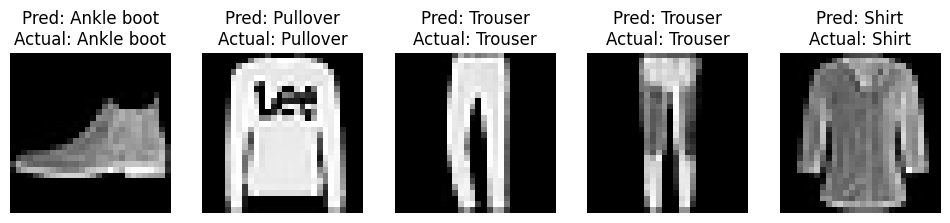

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def get_data_loaders(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
    test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, epochs=20, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    best_loss = float("inf")
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

def predict_and_compare(model, test_loader, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load("best_model.pth"))
    model.to(device)
    model.eval()
    class_names = datasets.FashionMNIST.classes
    
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)
    
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
    
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Pred: {class_names[predictions[i]]}\nActual: {class_names[labels[i]]}")
        ax.axis("off")
    plt.show()

train_loader, val_loader, test_loader = get_data_loaders()
model = FashionMNISTCNN()
train_model(model, train_loader, val_loader)
predict_and_compare(model, test_loader)
